### Tf-idf를 사용한 분류기

In [34]:
import numpy as np
import pandas as pd
import nltk
import re
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# 데이터 로드
data = pd.read_csv("news_data_ML.csv")

# 제거할 패턴들을 리스트로 정의
patterns = [
    "헤드라인",
    "톱뉴스",
    "팩트체크",
    "포토",
    "영상",
    "자막뉴스",
    "클로징",
    "주요뉴스" 
]

# 리스트의 각 패턴을 '|'로 연결하여 정규 표현식을 만듦
patterns_to_remove = '|'.join([f"{pattern}" for pattern in patterns])

# 데이터에서 해당 패턴을 포함하는 제목 필터링
data = data[~data['title'].str.contains(patterns_to_remove, regex=True)]


def clean_title(text):
    """ 뉴스 제목에서 불필요한 패턴과 문자를 제거합니다. """
    text = re.sub(r'\[.*?\]', '', text)  # 대괄호 안의 텍스트 제거
    text = re.sub(r'[\'"“”‘’]', '', text)  # 모든 종류의 따옴표(일반, 특수) 제거
    return text.strip()  # 양쪽 공백 제거

data['cleaned_title'] = data['title'].apply(clean_title)
# 모델 학습, 예측, 평가 등의 과정에 'encoded_category' 사용
# 예: true_labels = data['encoded_category']

# 데이터 전처리 
data['tokenized_text'] = data['cleaned_title'].apply(word_tokenize)

# 훈련 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_title'], data['category'], test_size=0.3)

# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# 나이브 베이즈 모델 초기화 및 훈련
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# 모델 평가
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       IT/과학       0.00      0.00      0.00         7
          경제       1.00      0.06      0.12        16
          사회       0.64      0.97      0.77       136
       생활/문화       0.00      0.00      0.00        12
          정치       0.88      0.43      0.57        68

    accuracy                           0.68       239
   macro avg       0.50      0.29      0.29       239
weighted avg       0.68      0.68      0.61       239



C:\Users\endnj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\endnj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\endnj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### example_text에 원하는 제목을 입력해 예측 결과 확인

In [35]:
example_text = "EU, 반도체·AI 등 민감기술 투자·수출 통제 추진"

# 전체 텍스트에 대한 벡터 변환
example_text_vec = vectorizer.transform([example_text])  # 리스트로 감싸서 전달

# 예측 수행
predicted_category = model.predict(example_text_vec)

print(f"제목: {example_text} \n예측된 카테고리: {predicted_category[0]}")

제목: EU, 반도체·AI 등 민감기술 투자·수출 통제 추진 
예측된 카테고리: 사회


Multinomial Naive Bayes 모델은 각 클래스에 대한 각 단어의 로그 조건부 확률을 feature_log_prob_ 속성에 저장한다.  
이 값을 사용하여 각 클래스에 대한 가장 중요한 단어들을 확인해보자.

In [36]:
import numpy as np

# TF-IDF 벡터라이저의 특성 이름 가져오기
feature_names = vectorizer.get_feature_names_out()

# 각 클래스에 대한 상위 N개 중요 단어를 추출하는 함수
def top_n_words_per_class(class_index, n=10):
    sorted_indices = model.feature_log_prob_[class_index, :].argsort()[::-1]
    top_n = feature_names[sorted_indices][:n]
    return top_n

# 각 클래스에 대한 상위 단어들 출력
for i in range(len(model.classes_)):
    class_name = model.classes_[i]
    top_words = top_n_words_per_class(i, 10)
    print(f"Class: {class_name}")
    print(f"Top words: {', '.join(top_words)}\n")


Class: IT/과학
Top words: 시리즈, 갤럭시, 예산, 개통, 사전, s24, 불황, 마침내, 반도체업계, 흑자전환

Class: 경제
Top words: 역대, 최대, 플랫폼법, 공정위, 안덕근, 충전소, lpg, 현대차, 영업익, 장관

Class: 사회
Top words: 양승태, 배현진, 무죄, 새로운미래, 이낙연, 1심, 사법농단, 50인, 세팍타크로팀, 중대재해처벌법

Class: 생활/문화
Top words: 유인촌, 장관, 문체부, 바우길, 강릉, 2024년, 운세, 오늘의, 01월, 찾은

Class: 정치
Top words: 배현진, 한동훈, 31, 피습, 대통령, 의원, 불화살, 시험발사, 국민, 쌍특검법



In [37]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# 데이터 로드 및 전처리
data = pd.read_csv("news_data_ML.csv")

# 파이프라인 생성: TF-IDF 벡터화 및 나이브 베이즈 모델
pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())

# 교차 검증 수행
cross_val_scores = cross_val_score(pipeline, data['title'], data['category'], cv=10, scoring='accuracy')

# 교차 검증 결과 출력
print("교차 검증 정확도 점수:", cross_val_scores)
print("평균 정확도:", np.mean(cross_val_scores))


교차 검증 정확도 점수: [0.66326531 0.68367347 0.75510204 0.73195876 0.73195876 0.73195876
 0.73195876 0.71134021 0.71134021 0.65979381]
평균 정확도: 0.7112350094677046


### Word2Vec를 사용한 분류기

In [38]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 데이터 로드 및 전처리
data = pd.read_csv("news_data_ML.csv")

# 제거할 패턴들을 리스트로 정의
patterns = [
    "헤드라인",
    "톱뉴스",
    "팩트체크",
    "포토",
    "영상",
    "자막뉴스",
    "클로징",
    "주요뉴스" 
]

# 리스트의 각 패턴을 '|'로 연결하여 정규 표현식을 만듦
patterns_to_remove = '|'.join([f"{pattern}" for pattern in patterns])

# 데이터에서 해당 패턴을 포함하는 제목 필터링
data = data[~data['title'].str.contains(patterns_to_remove, regex=True)]


def clean_title(text):
    """ 뉴스 제목에서 불필요한 패턴과 문자를 제거합니다. """
    text = re.sub(r'\[.*?\]', '', text)  # 대괄호 안의 텍스트 제거
    text = re.sub(r'[\'"“”‘’]', '', text)  # 모든 종류의 따옴표(일반, 특수) 제거
    return text.strip()  # 양쪽 공백 제거

data['cleaned_title'] = data['title'].apply(clean_title)


data['tokenized_text'] = data['title'].apply(word_tokenize)
# Word2Vec 모델 훈련
w2v_model = Word2Vec(data['tokenized_text'], vector_size=100, window=5, min_count=1, workers=4)

# 문서별 평균 벡터 계산 함수
def document_vector(doc):
    # 단어 벡터의 평균을 계산
    doc = [word for word in doc if word in w2v_model.wv.index_to_key]
    return np.mean(w2v_model.wv[doc], axis=0)

# 각 문서에 대한 문서 벡터 생성
data['doc_vector'] = data['tokenized_text'].apply(document_vector)

# 훈련 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(data['doc_vector'].tolist(), data['category'], test_size=0.3)

# 분류기 훈련
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

# 예측을 위한 함수 정의
def predict_category(text, w2v_model, classifier):
    # 텍스트를 토큰화하고 Word2Vec 모델을 사용하여 벡터 생성
    tokenized_text = text.split()
    doc_vector = document_vector(tokenized_text)
    if np.isnan(doc_vector).any():
        doc_vector = np.zeros(w2v_model.vector_size)
    
    # 예측 수행
    predicted_category = classifier.predict([doc_vector])
    return predicted_category[0]

# 모델 평가
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       1.00      0.12      0.22         8
          경제       1.00      0.15      0.26        27
          사회       0.70      0.95      0.80       148
       생활/문화       1.00      0.11      0.20         9
          정치       0.70      0.49      0.57        47

    accuracy                           0.71       239
   macro avg       0.88      0.36      0.41       239
weighted avg       0.75      0.71      0.66       239



Word2Vec 모델은 훈련 데이터에 있는 단어들만 학습한다. 만약 예측하려는 텍스트에 훈련 데이터에 없는 새로운 단어가 포함되어 있다면, 이 단어들은 Word2Vec 모델에 의해 벡터로 변환되지 않기 때문에, 제대로 예측하지 못하거나 에러가 나온다.
즉 뉴스 제목으로 카테고리를 예측하는 모델을 만들 때 Word2Vec 모델을 사용한다면, 뉴스 제목에 어떤 단어가 들어와도 그 단어가 훈련 데이터 안에 있어야 하도록 어마어마한 양의 훈련 데이터가 필요하다는 뜻이다.

In [39]:
#제목에 있는 단어가 학습 데이터에 모두 있는 경우
example_text_1 = "“유튜브만 믿어!”…극혐 정치·가짜뉴스 키우는 SNS"
predicted_category_1 = predict_category(example_text_1, w2v_model, classifier)
print(f"제목: {example_text_1} \n예측된 카테고리: {predicted_category_1}")

# #제목에 학습 데이터에 없는 단어가 있는 경우 - ValueError: need at least one array to concatenate
# example_text_2 = "한국원자력학회, 고준위 방폐물 특별법 처리 촉구"
# predicted_category_2 = predict_category(example_text_2, w2v_model, classifier)
# print(f"제목: {example_text_2} \n예측된 카테고리: {predicted_category_2}")

제목: “유튜브만 믿어!”…극혐 정치·가짜뉴스 키우는 SNS 
예측된 카테고리: 사회


Word2Vec에서 각 특성은 Word2Vec 모델에 의해 생성된 개별 차원(word -> vector)을 나타내기 때문에, 카테고리 결정에 영향을 미치는 구체적인 단어를 파악하고자 한다면 TF-IDF를 사용해야 한다.

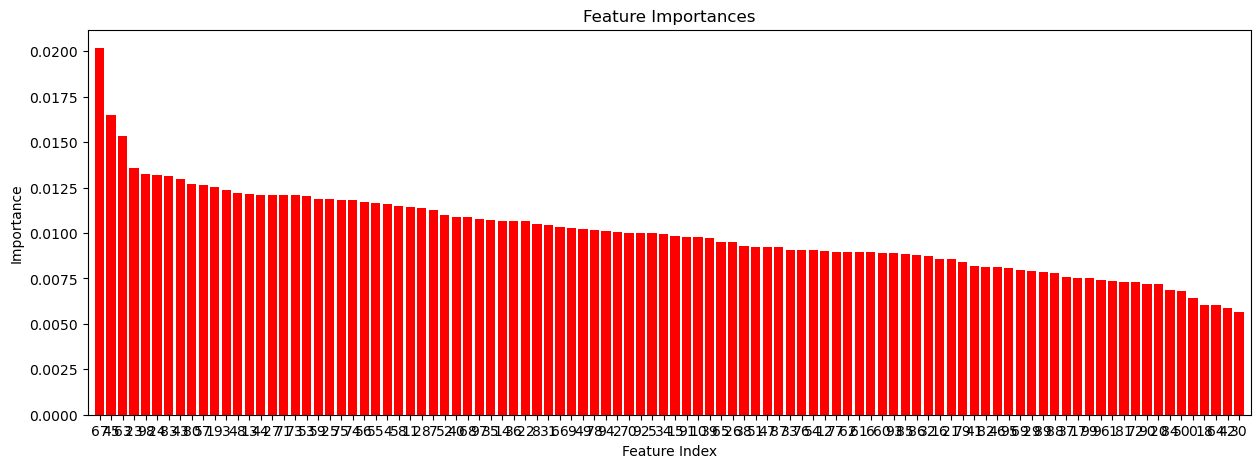

In [40]:
import matplotlib.pyplot as plt

# RandomForestClassifier의 feature importance 추출
importances = classifier.feature_importances_

# feature importance를 시각화
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(15, 5))
plt.title("Feature Importances")
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), indices)
plt.xlim([-1, len(indices)])
plt.xlabel('Feature Index') #xlabel 이 단어가 아닌 벡터로 나온다.
plt.ylabel('Importance')
plt.show()

In [41]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

#전체 문서 벡터를 NumPy 배열로 변환
X = np.array(data['doc_vector'].tolist())
y = data['category']

# RandomForestClassifier 초기화
classifier = RandomForestClassifier()

# 교차 검증 실행 (예: 5-폴드 교차 검증)
scores = cross_val_score(classifier, X, y, cv=10)

# 평균 정확도 출력
print("교차 검증 정확도:", scores)
print("평균 정확도:", np.mean(scores))

교차 검증 정확도: [0.6        0.5875     0.6625     0.7        0.6125     0.64556962
 0.59493671 0.60759494 0.59493671 0.60759494]
평균 정확도: 0.6213132911392404
